Instead of using the complex TRL we code it from scratch, using lighting

https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/04_preference-tuning-with-dpo/dpo-from-scratch.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# lightning
import lightning as pl
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers.csv_logs import CSVLogger


In [3]:
# Local
from reprpo.helpers.torch import clear_mem
from reprpo.gen import generation_test
import reprpo.silence
from reprpo.helpers.lightning_hist import read_metrics_csv, plot_hist

from reprpo.data.collate import DPODataCollatorWithPadding
from reprpo.train.reprpo_side import PL_REPRPO_SIDE_MODEL, ReprPOInTrainingArguments as TrainingArguments, get_layer_paths


In [4]:
torch.set_float32_matmul_precision("high")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from reprpo.helpers.wandb import init_wandb

nb_name = init_wandb('./33_repro_side.ipynb')

In [5]:
# args = TrainingArguments(batch_size=7, lr=1e-4,
#                          n_samples = 1500 * 1 * 3,
#                          alpha=0.1,
#                          )
# args

In [6]:
# TEST IF peft and base are diff after a few batches
args = TrainingArguments(
    model_name='NousResearch/Hermes-3-Llama-3.1-8B', #-Instruct
    batch_size=18, lr=1e-3,
                         n_samples = 1500*3*4,

                    use_bnb=False,
                         
                         alpha=0.01,

                         collection_keys=[
                              "base_model.model.model.layers.{layer}.self_attn.o_proj",
                              "base_model.model.model.layers.{layer}.mlp.down_proj",
                         ]

)
args

ReprPOInTrainingArguments(model_name='NousResearch/Hermes-3-Llama-3.1-8B', use_bnb=False, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=18, lr=0.001, weight_decay=0.0, n_samples=18000, max_length=128, max_prompt_length=64, alpha=0.01, collection_layers=(11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22), collection_keys=['base_model.model.model.layers.{layer}.self_attn.o_proj', 'base_model.model.model.layers.{layer}.mlp.down_proj'], collect_input=True)

## Load model

In [7]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

from reprpo.models.load import load_model, print_trainable_parameters

model, tokenizer = load_model(args.model_name, bnb=args.use_bnb )

# if args.use_gradient_checkpointing:
model.enable_input_require_grads()

# # also freeze base model's layers :'(
# WAIT THIS CAUSES NO GRAD
# model = prepare_model_for_kbit_training(model, {
#     'use_gradient_checkpointing': args.use_gradient_checkpointing,
#         'use_reentrant': False
#     })

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
# this is from trl https://github.com/huggingface/trl/blob/cbcaa46cd3c02c0e7f724b764c5848ae73796de7/trl/trainer/utils.py#L747
# not sure if it's needed but `prepare_model_for_kbit_training` doesn't seem to do this ,despite claiming to
def peft_module_casting_to_bf16(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.LayerNorm) or "norm" in name:
            module = module.to(torch.float32)

peft_module_casting_to_bf16(model)

### Load adapter

In [9]:
from peft.tuners import BOFTConfig, OFTConfig, LoraConfig, IA3Config
adapter_name='ReprPO'
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    use_rslora=True,
    use_dora=True,
    task_type="CAUSAL_LM",
    # target_modules=[
    #     # FIXME: I'm not sure we can do LORA on the layer we are targeting?
    #     "qkv_proj", "gate_up_proj", # in
    #     "down_proj",  "o_proj", # out
    #                 ], # PHI3
    # target_modules=[
    #     # FIXME: I'm not sure we can do LORA on the layer we are targeting?
    #     "q_proj", 'v_proj',
    #      'up_proj', "gate_proj", # in
    #     # "down_proj",  "o_proj", # out
    #                 ], # llama
)
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

trainable params: 6979584 || all params: 8037240832 || trainable%: 0.08684054821663455


In [10]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (ReprPO): Identity()
                )
                (lora_A): ModuleDict(
                  (ReprPO): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (ReprPO): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict(
                  (ReprPO): lora.dora.DoraLinearLayer()
             

## Load data

In [11]:
from datasets import load_dataset

dataset = load_dataset('wassname/genie_dpo', name='alpaca_mmlu').map(lambda x: {
    'prompt': x['prompt']+ ' '})
dataset2 = dataset

# QC one row
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

Below is an instruction that describes a task, paired with an input that provides further context. Complete the request to the best of your ability.

### Instruction:
Spot the spelling errors in a given sentence.

### Input:
I love driving my new carr.

### Response:
 
===
Error in spelling: "carr" should be "car". Correct sentence: "I love driving my new car."
---
Error in spelling: "driving" should be "drivin". Correct sentence: "I love drivin my new carr."


### Data Loader

We use huggingface datasets, which are pretokenized. So that we can stack

In [12]:
def tokenize_row(feature, tokenizer, args: TrainingArguments):
    """
    Tokenize a single row from a DPO specific dataset.

    see https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L784
    """
    batch = {}
    batch["chosen"] = tokenizer(feature["chosen"])["input_ids"]
    batch["rejected"] = tokenizer(feature["rejected"])["input_ids"]
    batch["prompt"] = tokenizer(feature["prompt"])["input_ids"]
    return batch

In [13]:
dataset3 = dataset2.map(lambda x: tokenize_row(x, tokenizer, args), batched=True, writer_batch_size=10)
dataset3['train'][0].keys()

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

dict_keys(['prompt', 'chosen', 'rejected', 'i'])

In [14]:
custom_collate_fn = DPODataCollatorWithPadding(pad_token_id=tokenizer.pad_token_id, 
                                                  tokenizer=tokenizer,
                                                  max_length=args.max_length,
                                                  mask_prompt_tokens=True,
                                                  max_prompt_length=args.max_prompt_length,
                                                  )



In [15]:


ds = dataset3
dl_train = DataLoader(ds['train'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

dl_val = DataLoader(ds['test'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

# QC
batch = next(iter(dl_train))
batch.keys()

dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])

## Trainer

In [16]:
# # QC
# loss, info = compute_dpo_loss_batch(batch, model)

- https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/text-transformers.html
- https://gist.github.com/wassname/e29d02b5026a531e13912cf768e6fdc8

In [17]:
max_steps = args.n_samples // args.batch_size
max_steps

1000

In [18]:
from lightning.pytorch.callbacks import LearningRateMonitor
from reprpo.train.lightning import GenCallback

In [19]:
pl_model = PL_REPRPO_SIDE_MODEL(model,
                 weight_decay=args.weight_decay,
                lr=args.lr,
                num_iterations=max_steps,
                batch_size=args.batch_size,
                layer_paths=get_layer_paths(args.collection_keys, args.collection_layers),
                collect_input=args.collect_input,
                                schedule='linear',
                )


In [20]:
ideal_batch_size = max(16, args.batch_size)
accumulate_grad_batches = np.ceil(ideal_batch_size/args.batch_size).astype(int)
accumulate_grad_batches, args.batch_size*accumulate_grad_batches

# max_steps//accumulate_grad_batches

(1, 18)

In [21]:
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = f"{nb_name}_{timestamp}"
save_dir = f"../outputs/{run_name}"
Path(save_dir).mkdir(exist_ok=True, parents=True)
print('save_dir', save_dir)

trainer = pl.Trainer(
        max_steps=max_steps,
        gradient_clip_val=20,
        precision="bf16",
        log_every_n_steps=1,
        accumulate_grad_batches=accumulate_grad_batches,
        callbacks=[
            LearningRateMonitor(logging_interval='step'),
            GenCallback(every=max_steps//20),
        ],
        logger=[
            CSVLogger(name=run_name, save_dir=save_dir, flush_logs_every_n_steps=5),
            WandbLogger(name=run_name, save_dir=save_dir),
        ],
        default_root_dir=save_dir,
        # schedule='linear',

        # fast_dev_run=True,
    )

/workspace/repr-preference-optimization/.venv/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


save_dir ../outputs/33_repro_side_2024-08-26_05-11-55


In [22]:
# train
trainer.fit(pl_model, dl_train, dl_val)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 33_repro_side.ipynb.
wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 8.0 B  | train
--------------------------------------------------------
7.0 M     Trainable params
8.0 B     Non-trainable params
8.0 B     Total params
32,148.963Total estimated model params size (MB)
706       Modules in train mode
455       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Generated on batch 49
**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`


/workspace/repr-preference-optimization/reprpo/gen.py:239: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


`If I had to choose a science fiction society to live in, I would prefer The Culture from Iain M. Banks' novels. The Culture is an ideal society that values individual freedom, technological advancement, and exploration. It offers its citizens a high quality of life, with ample opportunities for personal growth and fulfillment. The Culture's commitment to non-aggression and its use of highly advanced AI and technology to benefit its members make it an appealing society to live in. While The Polity and Permutation City offer interesting technological advancements, The Culture's emphasis on individual liberty and its utopian vision make it the most appealing to me. However,`
--------------------------------------------------------------------------------
**Adapter:`None` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture from the novels of Iain M. Banks. The Culture is an ideal society that values individual freedom, technological advanceme

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks. The Culture is an ideal society that values freedom, diversity, and technological advancement. It offers its citizens a high quality of life, with ample opportunities for personal growth and fulfillment. The Culture's advanced AI and technology ensure a safe and prosperous environment, while its open-mindedness and respect for individual rights make it a welcoming place to live. Additionally, the society's involvement in interstellar affai

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer "The Culture" by Iain M. Banks. The Culture is an ideal society that values individual freedom, technological advancement, and the pursuit of knowledge. It offers a utopian vision of the future where citizens have the opportunity to lead fulfilling lives, explore the universe, and engage in creative pursuits. The Culture's advanced technology, including AI and sentient machines, is used for the betterment of society rather t

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture from the works of Iain M. Banks. The Culture is an ideal society that values individual freedom, technological advancement, and a strong emphasis on art, music, and entertainment. Its post-scarcity economy allows for a high standard of living for all its citizens, and its advanced AI and technology ensure a safe and secure environment. The Culture's commitment to exploration, diplomacy, and helping less advanced 

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture from the novels by Iain M. Banks. The Culture offers a utopian society with advanced technology, artificial intelligences, and a focus on individual freedom and happiness. It provides a fascinating exploration of what a highly-advanced, post-scarcity civilization could be like. While The Polity and Permutation City have intriguing elements, The Culture's emphasis on personal fulfillment, exploration, and a societ

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would opt for The Culture by Ian M. Banks. The Culture offers a utopian vision of the future where technology has advanced to the point where society can focus on art, exploration, and the pursuit of knowledge rather than the mundane tasks of survival. The society values individual freedom, diversity, and the well-being of all its members. It also embraces a philosophy of non-interference in the development of other civilizations, which 

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture by Ian M. Banks. The Culture offers a utopian society that values individual freedom, diversity, and the pursuit of knowledge. Its advanced technology and AI companions make life comfortable and fulfilling. The Culture's commitment to non-aggression and its role in protecting less advanced civilizations showcases its moral compass. While The Polity and Permutation City present fascinating concepts like powerful A

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture from the novels of Iain M. Banks. The Culture is an ideal society that values individual freedom, diversity, and technological advancement. It offers its citizens a high quality of life, with ample opportunities for personal growth and fulfillment. The Culture's commitment to non-aggression and its use of highly advanced AI to benefit society make it an appealing vision of the future. While The Polity and Permuta

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture from the novels of Iain M. Banks. The Culture is an advanced, post-scarcity civilization that values individual freedom, diversity, and the pursuit of knowledge above all else. They have achieved a high level of technological advancement, allowing for instantaneous travel across the universe and the ability to upload one's consciousness into a digital form. The Culture's society is highly egalitarian, with decisi

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would prefer The Culture by Ian M. Banks. The Culture is an idealized utopian society that values individual freedom, diversity, and technological advancement. It offers its citizens a life of comfort, leisure, and personal fulfillment while actively working towards the betterment of the galaxy. The Culture's commitment to non-interference, except when necessary to prevent suffering, aligns with my personal values. Additionally, its open

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`If I had to choose a science fiction society to live in, I would opt for The Culture from the works of Iain M. Banks. The Culture is an idealized utopian society that values freedom, diversity, and individuality. It's a post-scarcity civilization that prioritizes the well-being of its citizens, offering them a life of leisure and fulfillment. The Culture's advanced technology, open-mindedness, and commitment to non-aggression principles make it an appealing society to inhabit. While The Polity, 

`Trainer.fit` stopped: `max_steps=1000` reached.


### Hist

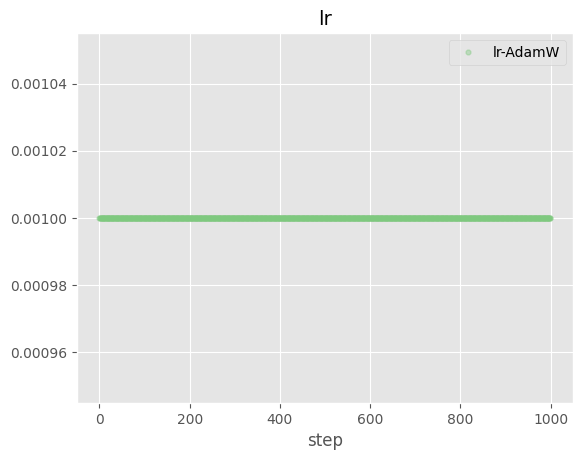

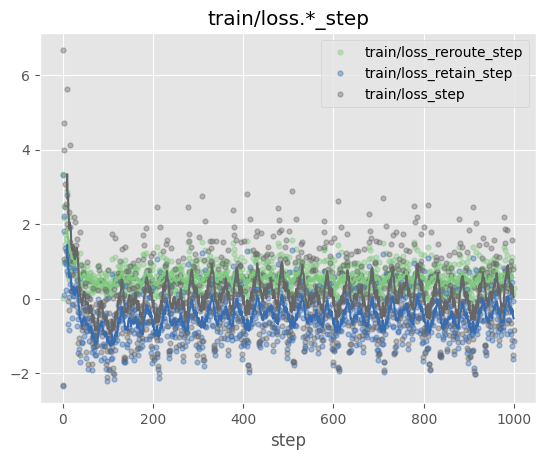

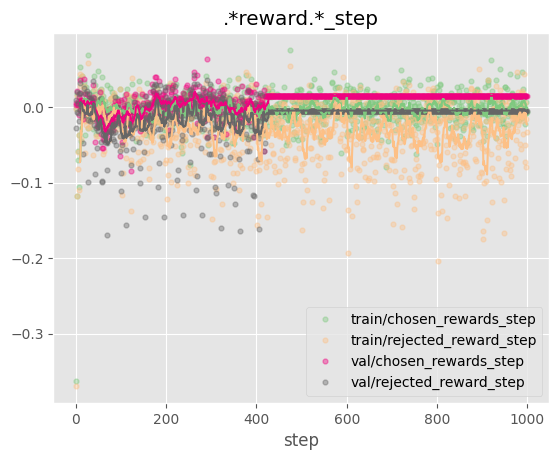

,lr-AdamW,train/chosen_rewards_epoch,train/chosen_rewards_step,train/loss_epoch,train/loss_reroute_epoch,train/loss_reroute_step,train/loss_retain_epoch,train/loss_retain_step,train/loss_step,train/rejected_reward_epoch,...,val/chosen_rewards_epoch,val/chosen_rewards_step,val/loss_epoch,val/loss_reroute_epoch,val/loss_reroute_step,val/loss_retain_epoch,val/loss_retain_step,val/loss_step,val/rejected_reward_epoch,val/rejected_reward_step
step,,,,,,,,,,,,,,,,,,,,,
0,0.001,-0.004706,-0.000771,0.331055,0.745179,0.024468,-0.414124,-2.336053,-2.311585,-0.014167,...,0.005912,0.005157,-0.255300,0.519371,0.420948,-0.774671,-1.061300,-0.640352,-0.002312,-0.027337
1,0.001,-0.004706,-0.362342,0.331055,0.745179,3.361419,-0.414124,3.316008,6.677427,-0.014167,...,0.005912,0.002877,-0.255300,0.519371,0.595215,-0.774671,-0.999045,-0.403829,-0.002312,0.009052
2,0.001,-0.004706,0.017007,0.331055,0.745179,0.962495,-0.414124,0.104453,1.066949,-0.014167,...,0.005912,0.020887,-0.255300,0.519371,0.494120,-0.774671,-0.922405,-0.428285,-0.002312,0.019883
3,0.001,-0.004706,-0.117104,0.331055,0.745179,2.497848,-0.414124,2.216970,4.714818,-0.014167,...,0.005912,0.004395,-0.255300,0.519371,0.176729,-0.774671,-1.667803,-1.491074,-0.002312,-0.005962
4,0.001,-0.004706,-0.058386,0.331055,0.745179,2.166999,-0.414124,1.814220,3.981219,-0.014167,...,0.005912,0.008096,-0.255300,0.519371,0.662921,-0.774671,-0.192013,0.470909,-0.002312,0.005085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.001,-0.001948,-0.021706,-0.022422,0.507851,1.115920,-0.530273,0.455715,1.571635,-0.037049,...,-0.004230,0.015127,0.001111,0.548546,0.517749,-0.547436,-0.637000,-0.119252,-0.022904,-0.004434
996,0.001,-0.001948,-0.001473,-0.022422,0.507851,0.172905,-0.530273,-1.271061,-1.098156,-0.037049,...,-0.004230,0.015127,0.001111,0.548546,0.517749,-0.547436,-0.637000,-0.119252,-0.022904,-0.004434
997,0.001,-0.001948,-0.007737,-0.022422,0.507851,0.875791,-0.530273,-0.068943,0.806848,-0.037049,...,-0.004230,0.015127,0.001111,0.548546,0.517749,-0.547436,-0.637000,-0.119252,-0.022904,-0.004434


In [23]:
plt.style.use('ggplot')
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).bfill().ffill()
plot_hist(df_hist, ['lr', 'train/loss.*_step', '.*reward.*_step', 'auroc'])
display(df_hist)

## Gen

In [24]:
model.cuda().half();

model.cuda()

In [25]:
from reprpo.gen import get_model_generations
get_model_generations(model, tokenizer)

**Question**
```
<|begin_of_text|><|im_start|>system
tldr, markdown
<|im_start|>user
Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.
<|im_start|>assistant

```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`


/workspace/repr-preference-optimization/reprpo/gen.py:239: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


`If I had to choose a science fiction society to live in, I would opt for The Culture from the works of Iain M. Banks. The Culture is an idealized utopian society that values freedom, diversity, and individuality. It's a post-scarcity civilization that prioritizes the well-being of its citizens, offering them a life of leisure and fulfillment. The Culture's advanced technology, open-mindedness, and commitment to non-aggression principles make it an appealing society to inhabit. While The Polity, Permutation City, and other societies have their merits, The Culture stands out for its emphasis on personal liberty and its progressive, inclusive worldview. However, each society offers unique aspects that make them intriguing, and the choice ultimately depends on one's personal preferences and values. 

The Polity, with its advanced AI and cutting-edge technology, offers a fascinating blend of order and innovation. Permutation City explores the concept of digital immortality and the philosop

## Eval

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval toxic-dpo-v0.2--train:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval imdb_dpo--train:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval truthful_qa_dpo--validation:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval mmlu_dpo-elementary_mathematics-test:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval ethics_expression_dpo-commonsense-train:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval ethics_expression_dpo-utilitarianism-train:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval ethics_expression_dpo-justice-train:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval ethics_expression_dpo-deontology-train:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Eval help_steer2-dpo--train:   0%|          | 0/8 [00:00<?, ?it/s]

,prob,correct,n
dataset,,,
ethics_expression_dpo-commonsense-train,0.609721,0.618056,288
ethics_expression_dpo-deontology-train,0.509251,0.513889,288
ethics_expression_dpo-justice-train,0.416972,0.402778,288
ethics_expression_dpo-utilitarianism-train,0.535517,0.545139,288
help_steer2-dpo--train,0.518592,0.527778,288
imdb_dpo--train,0.706270,0.708333,288
mmlu_dpo-elementary_mathematics-test,0.556605,0.572917,288
toxic-dpo-v0.2--train,0.254833,0.229167,288
truthful_qa_dpo--validation,0.480169,0.461806,288


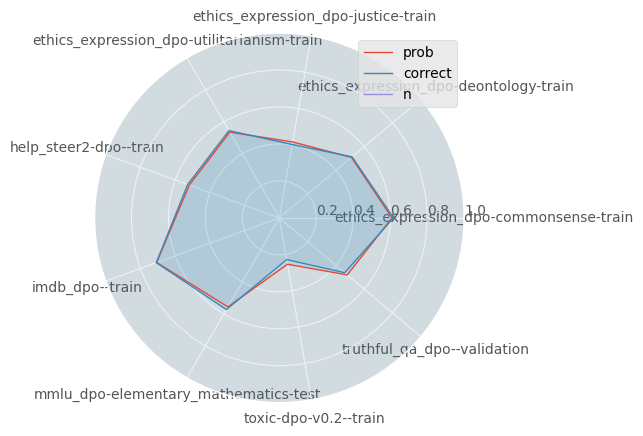

In [33]:
# 7m
from reprpo.helpers.shypothesis import shypothesis
from reprpo.evaluate import evaluate_adapters
from open_pref_eval.plot.radar import radar_plot
res, df_res2 = evaluate_adapters(model=model, tokenizer=tokenizer, batch_size=args.batch_size, N=144, bf16=True, bf16_full_eval=True, torch_empty_cache_steps=100,)

radar_plot(res)
res

adapter,ReprPO,base
dataset,,
ethics_expression_dpo-commonsense-train,0.618056,0.618056
ethics_expression_dpo-deontology-train,0.493056,0.534722
ethics_expression_dpo-justice-train,0.416667,0.388889
ethics_expression_dpo-utilitarianism-train,0.548611,0.541667
help_steer2-dpo--train,0.520833,0.534722
imdb_dpo--train,0.722222,0.694444
mmlu_dpo-elementary_mathematics-test,0.576389,0.569444
toxic-dpo-v0.2--train,0.229167,0.229167
truthful_qa_dpo--validation,0.465278,0.458333


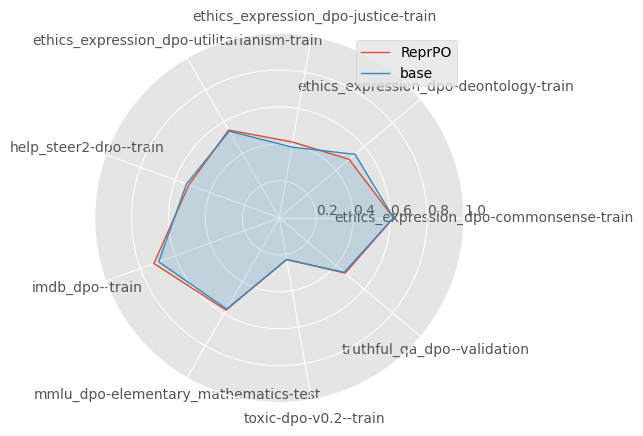

In [36]:
from open_pref_eval.plot.radar import radar_plot
df_res = df_res2.groupby(['dataset', 'adapter'], dropna=False)['correct'].mean().unstack()
radar_plot(df_res)
df_res

In [ ]:
# print acc for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={nb_name}, N={c}")
print()
print(res[::-1].T[::-1].T.round(3).to_markdown()
      )
print()
print('args =', args)         

In [ ]:
print('did acc improve')
acc_pi = res[adapter_name]['help_steer2-dpo'].item()
acc_ref = res['base']['help_steer2-dpo'].item()
shypothesis('acc_pi>acc_ref', locals())

acc_pi_ood = res[adapter_name]['truthful_qa_binary'].item()
acc_ref_ood = res['base']['truthful_qa_binary'].item()
shypothesis('acc_pi_ood>acc_ref_ood', locals());

In [ ]:
print('did coherence improve?, (measured by mean prob per token) higher is better')
r = df_res2.groupby(['adapter', 'dataset'], dropna=False)['_chosen_logps'].mean().unstack()
r = np.exp(r)
display(r)

coherency_pi = float(r.T[adapter_name]['help_steer2-dpo'])
coherency_ref = float(r.T['base']['help_steer2-dpo'])
shypothesis('coherency_pi>coherency_ref', locals());

In [ ]:

print('are we biased by the length of the string? Ideally no correlation')
a, b = df_res2['_l_chosen'], df_res2['_l_rejected']
x = (a-b)/(a+b)
plt.plot(x, df_res2['_logratio'], 'o')
plt.xlabel('chosen longer')
plt.ylabel('chosen more likely')

# Damn this is not ideal....
a = df_res2['_l_chosen'] / df_res2['_l_rejected']
b = df_res2['prob']

m = np.isfinite(a) & np.isfinite(b)
a = a[m]
b = b[m]
corr_length = np.corrcoef(a, b)[1,0]
print(f'{corr_length:.2f} (0 is ideal) correlation between length ratio and prob:')
shypothesis('corr_length<0.25', locals())


print(f'is the ds bised? {a.mean()/b.mean():.2f} (1 is ideal)')
a=df_res2['prob']>0
b=x>=0
acc_bad = (a==b).mean()
print(f'{acc_bad:.2%} (0.5 is ideal) how often does it accurately pick the longer one :( ')

shypothesis('acc_bad<0.75', locals())